In [5]:
####### IMPORTS
import pandas as pd
import geopandas
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import shapely.geometry
from IPython.core.display import display, HTML
from shapely.geometry import Polygon
display(HTML("<style>.container { width:100% !important; }</style>"))

C:\Users\rmpjazz\AppData\Local\Temp\ipykernel_46372\69770969.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [20]:
####### IMPORT DATA
cell_geo = pd.read_pickle("./dataframes/cell_geometry")
cell = geopandas.GeoDataFrame(cell_geo, columns=['geometry'], 
                                 crs='epsg:4326')

jsonfile = ('./mygeodata/fire_station_point.geojson')
fire_station_points = geopandas.read_file(jsonfile)

jsonfile = ('./ark28722-s73w23-geojson.json')
world = geopandas.read_file(jsonfile)

fires = pd.read_pickle("./dataframes/all_fires")
fires = fires[~fires["GIS_ACRES"].isnull()]
fires = fires[~fires.duplicated()]
fires = fires[~fires[["FIRE_NAME", "INC_NUM", "ALARM_DATE", "CONT_DATE", "CAUSE", "geometry"]].duplicated()]

fires = fires.loc[(fires["YEAR"] >= 2020) & (fires["YEAR"] <= 2023) & (fires["MONTH"] >= 6) & (fires["MONTH"] <= 10)]


####### WHICH DATA
dataframe_name = "./dataframes/2000-2019/nearest_interpolation_log_shifted10000"

dataframe = pd.read_pickle(dataframe_name)
cell["interpolated_value"] = dataframe.copy()

In [7]:
len(fires)

1451

In [8]:
# print(fires[["FIRE_NAME", "INC_NUM", "ALARM_DATE", "CONT_DATE", "CAUSE", "geometry"]].duplicated().sum())
# # len(fires)
# # print(fires.index[fires[["FIRE_NAME", "INC_NUM", "ALARM_DATE", "CONT_DATE", "CAUSE", "geometry"]].duplicated()])
# def get_consecutive_ranges(numbers: list[int]):
#     """Takes an input of integers in a list, yields the 
#     ranges of consecutive numbers that form the list."""
#     if not numbers:
#         return []

#     k = []
#     start,stop = None,None
#     for num in numbers:
#         if stop is None:
#             start, stop = num, num
#         elif stop == num-1:
#             stop += 1
#         else:
#             yield range(start,stop+1)
#             start, stop = num, num

#     yield range(start,stop+1)
# list_of_ranges = list(get_consecutive_ranges(list(fires.index[fires[["FIRE_NAME", "INC_NUM", "ALARM_DATE", "CONT_DATE", "CAUSE", "geometry"]].duplicated()])))
# print(list_of_ranges)

In [9]:
####### PLOTTING
import matplotlib.colors as colors

def plotter(dataset):
    cell["interpolated_value"] = dataset
    ax = cell.plot(column='interpolated_value', figsize=(10, 10), cmap='plasma', legend=True)
    world.to_crs(cell.crs).plot(ax = ax, color = "none", edgecolor = 'black', figsize = (8,8))
    return ax
def log_plotter(dataset):
    cell["interpolated_value"] = dataset
    ax = cell.plot(column='interpolated_value', figsize=(10, 10), cmap='plasma', norm=colors.SymLogNorm(vmin=cell["interpolated_value"].min(), vmax=cell["interpolated_value"].max(), linthresh = 0.02), legend=True)
    world.to_crs(cell.crs).plot(ax = ax, color = "none", edgecolor = 'black', figsize = (8,8))


<Axes: >

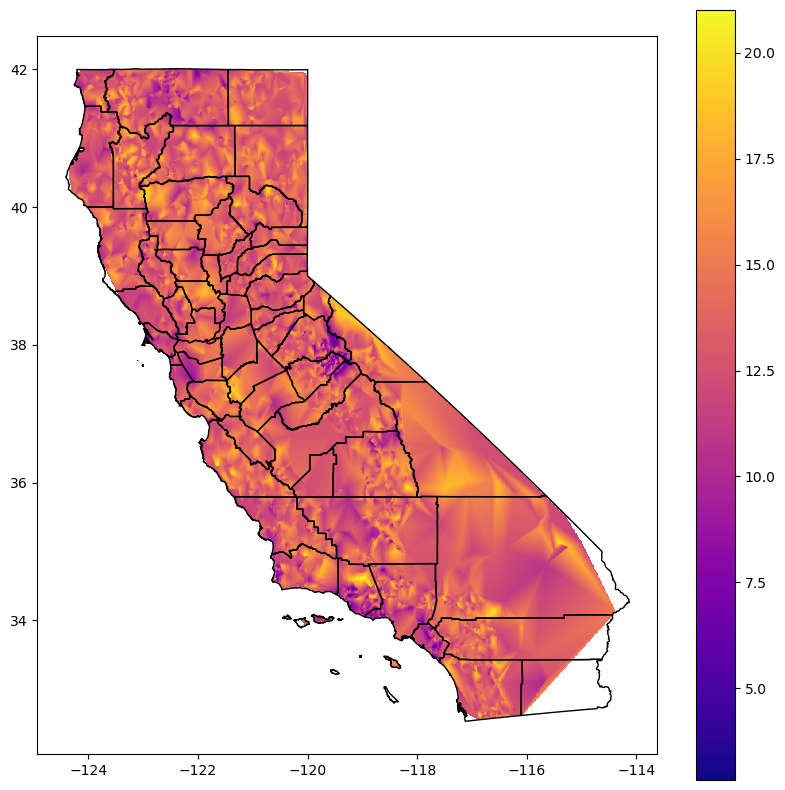

In [10]:
plotter(dataframe)

In [11]:
###### FIRESTATION POINT TO CELL
n_cells=828

cell_bounds = {}
for j in cell.index:
    cell_bounds[j] = cell["geometry"][j].bounds

positions_cell = [(int((cell["geometry"][i].centroid.x+125)*n_cells/12), int((cell["geometry"][i].centroid.y-32)*n_cells/12)) for i in cell.index]
cell["position"] = positions_cell
cell = cell.sort_values(by=["position"])

cell_size = (12)/n_cells
positions_fs = [(int((fire_station_points["geometry"][i].x+125)*n_cells/12), fire_station_points["geometry"][i].y) for i in fire_station_points.index]
fire_station_points["position"] = positions_fs
fire_station_points = fire_station_points.sort_values(by=["position"])

ind = {}
indj = 0
j = cell.index[indj]
for i in tqdm(fire_station_points.index):
    xc = fire_station_points["geometry"][i].x
    yc = fire_station_points["geometry"][i].y
    
    start = indj
    broken = False
    while not(cell_bounds[j][0] <= xc and cell_bounds[j][1] <= yc and cell_bounds[j][2] >= xc and cell_bounds[j][3] >= yc):
        indj += 1
        j = cell.index[indj]
        
        if (cell["position"][j][0] > fire_station_points["position"][i][0]):
            indj = start
            j = cell.index[indj]
            broken = True
            break
    if (broken):
        ind[i] = np.nan
    else:
        ind[i] = j
# null_firestations = []
# for x in ind.keys():
#     if (ind[x] is np.nan):
#         null_firestations.append(x)
# for i in fire_station_points.index:
#     if (np.isnan(ind[i]))
# fire_station_points = fire_station_points[[(not (i in null_firestations)) for i in fire_station_points.index]]


  0%|          | 0/1143 [00:00<?, ?it/s]

In [12]:
def check1(pos):
    score = 0
    for row in range(5):
        for column in range(5):
            new_ind = pos+column+row*760
            if new_ind in cell.index:
                score += cell["interpolated_value"][new_ind]
    return (score, 1, cell["geometry"][pos])
def check2(pos):
    score = 0
    for row in range(5):
        for column in range(5):
            new_ind = pos-column+row*760
            if new_ind in cell.index:
                score += cell["interpolated_value"][new_ind]
    return (score, 2, cell["geometry"][pos])
def check3(pos):
    score = 0
    for row in range(5):
        for column in range(5):
            new_ind = pos-column-row*760
            if new_ind in cell.index:
                score += cell["interpolated_value"][new_ind]
    return (score, 3, cell["geometry"][pos])
def check4(pos):
    score = 0
    for row in range(5):
        for column in range(5):
            new_ind = pos+column-row*760
            if new_ind in cell.index:
                score += cell["interpolated_value"][new_ind]
    return (score, 4, cell["geometry"][pos])
def check5(pos):
    score = 0
    for row in range(-2, 3):
        for column in range(5):
            new_ind = pos+column+row*760
            if new_ind in cell.index:
                score += cell["interpolated_value"][new_ind]
    return (score, 5, cell["geometry"][pos])
def check6(pos):
    score = 0
    for row in range(-2, 3):
        for column in range(5):
            new_ind = pos-column+row*760
            if new_ind in cell.index:
                score += cell["interpolated_value"][new_ind]
    return (score, 6, cell["geometry"][pos])
def check7(pos):
    score = 0
    for row in range(5):
        for column in range(-2, 3):
            new_ind = pos+column-row*760
            if new_ind in cell.index:
                score += cell["interpolated_value"][new_ind]
    return (score, 7, cell["geometry"][pos])
def check8(pos):
    score = 0
    for row in range(5):
        for column in range(-2, 3):
            new_ind = pos+column+row*760
            if new_ind in cell.index:
                score += cell["interpolated_value"][new_ind]
    return (score, 8, cell["geometry"][pos])
def check9(pos):
    score = 0
    for row in range(-2, 3):
        for column in range(-2, 3):
            new_ind = pos+column-row*760
            if new_ind in cell.index:
                score += cell["interpolated_value"][new_ind]
    return (score, 9, cell["geometry"][pos])      

def check(pos, di):
#     print(pos, di)
    if (di == 1):
        return check1(pos)
    if (di == 2):
        return check2(pos)
    if (di == 3):
        return check3(pos)
    if (di == 4):
        return check4(pos)
    if (di == 5):
        return check5(pos)
    if (di == 6):
        return check6(pos)
    if (di == 7):
        return check7(pos)
    if (di == 8):
        return check8(pos)
    if (di == 9):
        return check9(pos)

In [13]:
def null1(pos):
    score = 0
    for row in range(5):
        for column in range(5):
            new_ind = pos+column+row*760
            cell.loc[new_ind,"interpolated_value"] = 0
def null2(pos):
    score = 0
    for row in range(5):
        for column in range(5):
            new_ind = pos-column+row*760
            cell.loc[new_ind,"interpolated_value"] = 0
def null3(pos):
    score = 0
    for row in range(5):
        for column in range(5):
            new_ind = pos-column-row*760
            cell.loc[new_ind,"interpolated_value"] = 0
def null4(pos):
    score = 0
    for row in range(5):
        for column in range(5):
            new_ind = pos+column-row*760
            cell.loc[new_ind,"interpolated_value"] = 0
def null5(pos):
    score = 0
    for row in range(-2, 3):
        for column in range(5):
            new_ind = pos+column+row*760
            cell.loc[new_ind,"interpolated_value"] = 0
def null6(pos):
    score = 0
    for row in range(-2, 3):
        for column in range(5):
            new_ind = pos-column+row*760
            cell.loc[new_ind,"interpolated_value"] = 0
def null7(pos):
    score = 0
    for row in range(5):
        for column in range(-2, 3):
            new_ind = pos+column-row*760
            cell.loc[new_ind,"interpolated_value"] = 0
def null8(pos):
    score = 0
    for row in range(5):
        for column in range(-2, 3):
            new_ind = pos+column+row*760
            cell.loc[new_ind,"interpolated_value"] = 0
def null9(pos):
    score = 0
    for row in range(-2, 3):
        for column in range(-2, 3):
            new_ind = pos+column-row*760
            cell.loc[new_ind,"interpolated_value"] = 0

def null(pos, di):
    if (di == 1):
        null1(pos)
    if (di == 2):
        null2(pos)
    if (di == 3):
        null3(pos)
    if (di == 4):
        null4(pos)
    if (di == 5):
        null5(pos)
    if (di == 6):
        null6(pos)
    if (di == 7):
        null7(pos)
    if (di == 8):
        null8(pos)
    if (di == 9):
        null9(pos)

In [14]:
def go(coverage_number):    
    cell_size = (12)/n_cells
    cell["interpolated_value"] = dataframe.copy()
    
    ##### THIS EXISTS BTW
    cell["interpolated_value"] = cell["interpolated_value"].replace(np.nan, 0)

    all_coverages = []

    for i in fire_station_points.index:

        pos = ind[i]
        
        if (np.isnan(pos)):
            continue
        
        score, di, geo = check1(pos)
        all_coverages.append((score, pos, 1, i))

        
        score, di, geo = check2(pos)
        all_coverages.append((score, pos, 2, i))


        score, di, geo = check3(pos)
        all_coverages.append((score, pos, 3, i))


        score, di, geo = check4(pos)
        all_coverages.append((score, pos, 4, i))


        score, di, geo = check5(pos)
        all_coverages.append((score, pos, 5, i))


        score, di, geo = check6(pos)
        all_coverages.append((score, pos, 6, i))


        score, di, geo = check7(pos)
        all_coverages.append((score, pos, 7, i))


        score, di, geo = check8(pos)
        all_coverages.append((score, pos, 8, i))


        score, di, geo = check9(pos)
        all_coverages.append((score, pos, 9, i))

#     print(max_score, max_info)
#     print ((213.431915888972, 442461, 1, 606) in all_coverages)
    all_coverages.sort()
#     print(len(all_coverages))
#     print(all_coverages.index((213.431915888972, 442461, 1, 606)))
#     print(all_coverages[-1000:])
    selected_coverages = []
    summed_coverage = 0
    for i in tqdm(range(coverage_number)):
        summed_coverage += all_coverages[-1][0]
#         print(summed_coverage)
        selected_coverages.append(all_coverages[-1])
        null(all_coverages[-1][1], all_coverages[-1][2])
        all_coverages.pop(0)
        for coverage_num in range(-2*coverage_number, 0):
            score, di, geo = check(all_coverages[coverage_num][1], all_coverages[coverage_num][2])
    #         print(all_coverages[coverage_num])
    #         print((score, all_coverages[coverage_num][1], di, all_coverages[coverage_num][3]))
    #         print()
            all_coverages[coverage_num] = (score, all_coverages[coverage_num][1], di, all_coverages[coverage_num][3])

        all_coverages.sort()
    return summed_coverage, selected_coverages

In [15]:
def go_enhanced(coverage_numbers):
    coverage_numbers.sort()
    cell_size = (12)/n_cells
    cell["interpolated_value"] = dataframe.copy()
    
    ##### THIS EXISTS BTW
    cell["interpolated_value"] = cell["interpolated_value"].replace(np.nan, 0)

    all_coverages = []

    for i in fire_station_points.index:

        pos = ind[i]
        
        if (np.isnan(pos)):
            continue
        
        score, di, geo = check1(pos)
        all_coverages.append((score, pos, 1, i))

        
        score, di, geo = check2(pos)
        all_coverages.append((score, pos, 2, i))


        score, di, geo = check3(pos)
        all_coverages.append((score, pos, 3, i))


        score, di, geo = check4(pos)
        all_coverages.append((score, pos, 4, i))


        score, di, geo = check5(pos)
        all_coverages.append((score, pos, 5, i))


        score, di, geo = check6(pos)
        all_coverages.append((score, pos, 6, i))


        score, di, geo = check7(pos)
        all_coverages.append((score, pos, 7, i))


        score, di, geo = check8(pos)
        all_coverages.append((score, pos, 8, i))


        score, di, geo = check9(pos)
        all_coverages.append((score, pos, 9, i))

#     print(max_score, max_info)
#     print ((213.431915888972, 442461, 1, 606) in all_coverages)
    all_coverages.sort()
#     print(len(all_coverages))
#     print(all_coverages.index((213.431915888972, 442461, 1, 606)))
#     print(all_coverages[-1000:])
    ret = []
    selected_coverages = []
    summed_coverage = 0
    mex = max(coverage_numbers)
    for i in tqdm(range(mex)):
        if (i in coverage_numbers):
            ret.append((summed_coverage, selected_coverages.copy()))
        summed_coverage += all_coverages[-1][0]
#         print(summed_coverage)
        selected_coverages.append(all_coverages[-1])
        null(all_coverages[-1][1], all_coverages[-1][2])
        all_coverages.pop(0)
        for coverage_num in range(-2*mex, 0):
            score, di, geo = check(all_coverages[coverage_num][1], all_coverages[coverage_num][2])
    #         print(all_coverages[coverage_num])
    #         print((score, all_coverages[coverage_num][1], di, all_coverages[coverage_num][3]))
    #         print()
            all_coverages[coverage_num] = (score, all_coverages[coverage_num][1], di, all_coverages[coverage_num][3])

        all_coverages.sort()
    ret.append((summed_coverage, selected_coverages.copy()))
    return ret

In [16]:
def countcovered(coverages):
    totalcovered = 0
    ansar = np.array([False for i in range(len(fires))])
    for x in coverages:
        indx = x[1]
        minx, miny, maxx, maxy = cell["geometry"][indx].bounds
        if (x[2] == 1):
            pos = (minx, miny)
        if (x[2] == 2):
            pos = (minx, maxy-5*12/n_cells)
        if (x[2] == 3):
            pos = (maxx-5*12/n_cells, maxy-5*12/n_cells)
        if (x[2] == 4):
            pos = (maxx-5*12/n_cells, miny)
        if (x[2] == 5):
            pos = (minx-2*12/n_cells, miny)
        if (x[2] == 6):
            pos = (minx-2*12/n_cells, maxy-5*12/n_cells)
        if (x[2] == 7):
            pos = (maxx-5*12/n_cells, miny-2*12/n_cells)
        if (x[2] == 8):
            pos = (minx, miny-2*12/n_cells)
        if (x[2] == 9):
            pos = (minx-2*12/n_cells, miny-2*12/n_cells)
        polygon = Polygon([(pos[0], pos[1]), (pos[0] + 5*12/n_cells, pos[1]), (pos[0] + 5*12/n_cells, pos[1] + 5*12/n_cells), (pos[0], pos[1] + 5*12/n_cells)])
#         coverage_bounds = (pos[0], pos[1], , pos[1] + 5*12/n_cells)
#         print(polygon)
        ansar = np.logical_or(ansar, fires.overlaps(polygon))
        ansar = np.logical_or(ansar, fires.within(polygon))
        ansar = np.logical_or(ansar, fires.contains(polygon))
    return ansar.sum()
def countcoveredacres(coverages):
    totalcovered = 0
    ansar = np.array([False for i in range(len(fires))])
    for x in coverages:
        indx = x[1]
        minx, miny, maxx, maxy = cell["geometry"][indx].bounds
        if (x[2] == 1):
            pos = (minx, miny)
        if (x[2] == 2):
            pos = (minx, maxy-5*12/n_cells)
        if (x[2] == 3):
            pos = (maxx-5*12/n_cells, maxy-5*12/n_cells)
        if (x[2] == 4):
            pos = (maxx-5*12/n_cells, miny)
        if (x[2] == 5):
            pos = (minx-2*12/n_cells, miny)
        if (x[2] == 6):
            pos = (minx-2*12/n_cells, maxy-5*12/n_cells)
        if (x[2] == 7):
            pos = (maxx-5*12/n_cells, miny-2*12/n_cells)
        if (x[2] == 8):
            pos = (minx, miny-2*12/n_cells)
        if (x[2] == 9):
            pos = (minx-2*12/n_cells, miny-2*12/n_cells)
        polygon = Polygon([(pos[0], pos[1]), (pos[0] + 5*12/n_cells, pos[1]), (pos[0] + 5*12/n_cells, pos[1] + 5*12/n_cells), (pos[0], pos[1] + 5*12/n_cells)])
#         coverage_bounds = (pos[0], pos[1], , pos[1] + 5*12/n_cells)
#         print(polygon)
        ansar = np.logical_or(ansar, fires.overlaps(polygon))
        ansar = np.logical_or(ansar, fires.within(polygon))
        ansar = np.logical_or(ansar, fires.contains(polygon))
    return np.nansum(fires["GIS_ACRES"][ansar])

def countcoveredchoose(coverages):
    totalcovered = 0
    ansar = np.array([False for i in range(len(fires))])
    for x in coverages:
        indx = x[1]
        minx, miny, maxx, maxy = cell["geometry"][indx].bounds
        if (x[2] == 1):
            pos = (minx, miny)
        if (x[2] == 2):
            pos = (minx, maxy-5*12/n_cells)
        if (x[2] == 3):
            pos = (maxx-5*12/n_cells, maxy-5*12/n_cells)
        if (x[2] == 4):
            pos = (maxx-5*12/n_cells, miny)
        if (x[2] == 5):
            pos = (minx-2*12/n_cells, miny)
        if (x[2] == 6):
            pos = (minx-2*12/n_cells, maxy-5*12/n_cells)
        if (x[2] == 7):
            pos = (maxx-5*12/n_cells, miny-2*12/n_cells)
        if (x[2] == 8):
            pos = (minx, miny-2*12/n_cells)
        if (x[2] == 9):
            pos = (minx-2*12/n_cells, miny-2*12/n_cells)
        polygon = Polygon([(pos[0], pos[1]), (pos[0] + 5*12/n_cells, pos[1]), (pos[0] + 5*12/n_cells, pos[1] + 5*12/n_cells), (pos[0], pos[1] + 5*12/n_cells)])
#         coverage_bounds = (pos[0], pos[1], , pos[1] + 5*12/n_cells)
#         print(polygon)
        ansar = np.logical_or(ansar, fires.overlaps(polygon))
        ansar = np.logical_or(ansar, fires.within(polygon))
        ansar = np.logical_or(ansar, fires.contains(polygon))
    return ansar


In [21]:
drone_nums = [i for i in range(0, 701, 10)]
go_enh_results = go_enhanced(drone_nums)
x = drone_nums
y = []
y2 = []
y3 = []
for j in tqdm(go_enh_results):
    y.append(j[0])
    y2.append(countcovered(j[1]))
    y3.append(countcoveredacres(j[1]))

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

In [22]:
import pickle
with open('./tradeoff_results/brute_force_optimization+nearest_interpolation_log_shifted10000', 'wb') as fp:
    pickle.dump((drone_nums, y, y2, y3, go_enh_results), fp)

In [17]:
%matplotlib notebook
plt.figure(figsize = (10,10))
plt.plot(x, y)
plt.show()

In [15]:
%matplotlib notebook
plt.figure(figsize = (10,10))
plt.plot(x, y2)
plt.show()

In [18]:
%matplotlib notebook
plt.figure(figsize = (10,10))
plt.plot(x, y3)
plt.show()

In [15]:
def go_random(coverage_numbers):
    coverage_numbers.sort()
    cell_size = (12)/n_cells
    cell["interpolated_value"] = dataframe.copy()
    
    ##### THIS EXISTS BTW
    cell["interpolated_value"] = cell["interpolated_value"].replace(np.nan, 0)

    all_coverages = []

    for i in fire_station_points.index:

        pos = ind[i]
        
        if (np.isnan(pos)):
            continue
        
        score, di, geo = check1(pos)
        all_coverages.append((score, pos, 1, i))

        
        score, di, geo = check2(pos)
        all_coverages.append((score, pos, 2, i))


        score, di, geo = check3(pos)
        all_coverages.append((score, pos, 3, i))


        score, di, geo = check4(pos)
        all_coverages.append((score, pos, 4, i))


        score, di, geo = check5(pos)
        all_coverages.append((score, pos, 5, i))


        score, di, geo = check6(pos)
        all_coverages.append((score, pos, 6, i))


        score, di, geo = check7(pos)
        all_coverages.append((score, pos, 7, i))


        score, di, geo = check8(pos)
        all_coverages.append((score, pos, 8, i))


        score, di, geo = check9(pos)
        all_coverages.append((score, pos, 9, i))

    ret = []
    selected_coverages = []
    summed_coverage = 0
    mex = max(coverage_numbers)
    for i in tqdm(range(mex)):
        if (i in coverage_numbers):
            ret.append((summed_coverage, selected_coverages.copy()))
        chosen_ind = np.random.randint(0, len(all_coverages))
        summed_coverage += all_coverages[chosen_ind][0]
#         print(summed_coverage)
        selected_coverages.append(all_coverages[chosen_ind])
        null(all_coverages[chosen_ind][1], all_coverages[chosen_ind][2])
        all_coverages.pop(chosen_ind)
        for coverage_num in range(-2*mex, 0):
            score, di, geo = check(all_coverages[coverage_num][1], all_coverages[coverage_num][2])
    #         print(all_coverages[coverage_num])
    #         print((score, all_coverages[coverage_num][1], di, all_coverages[coverage_num][3]))
    #         print()
            all_coverages[coverage_num] = (score, all_coverages[coverage_num][1], di, all_coverages[coverage_num][3])

#         all_coverages.sort()
    ret.append((summed_coverage, selected_coverages.copy()))
    return ret

In [79]:
import pickle
with open('./tradeoff_results/rand5+linear_interp_log', 'wb') as fp:
    pickle.dump((drone_nums, y_2, y2_2, y3_2), fp)

In [78]:
drone_nums = [i for i in range(0, 701, 10)]
go_rand_results = go_random(drone_nums)
x = drone_nums
y_2 = []
y2_2 = []
y3_2 = []
for j in tqdm(go_rand_results):
    y_2.append(j[0])
    y2_2.append(countcovered(j[1]))
    y3_2.append(countcoveredacres(j[1]))

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

/Users/christopher/anaconda3/lib/python3.10/site-packages/shapely/predicates.py:853: RuntimeWarning: invalid value encountered in overlaps
  return lib.overlaps(a, b, **kwargs)


<IPython.core.display.Javascript object>


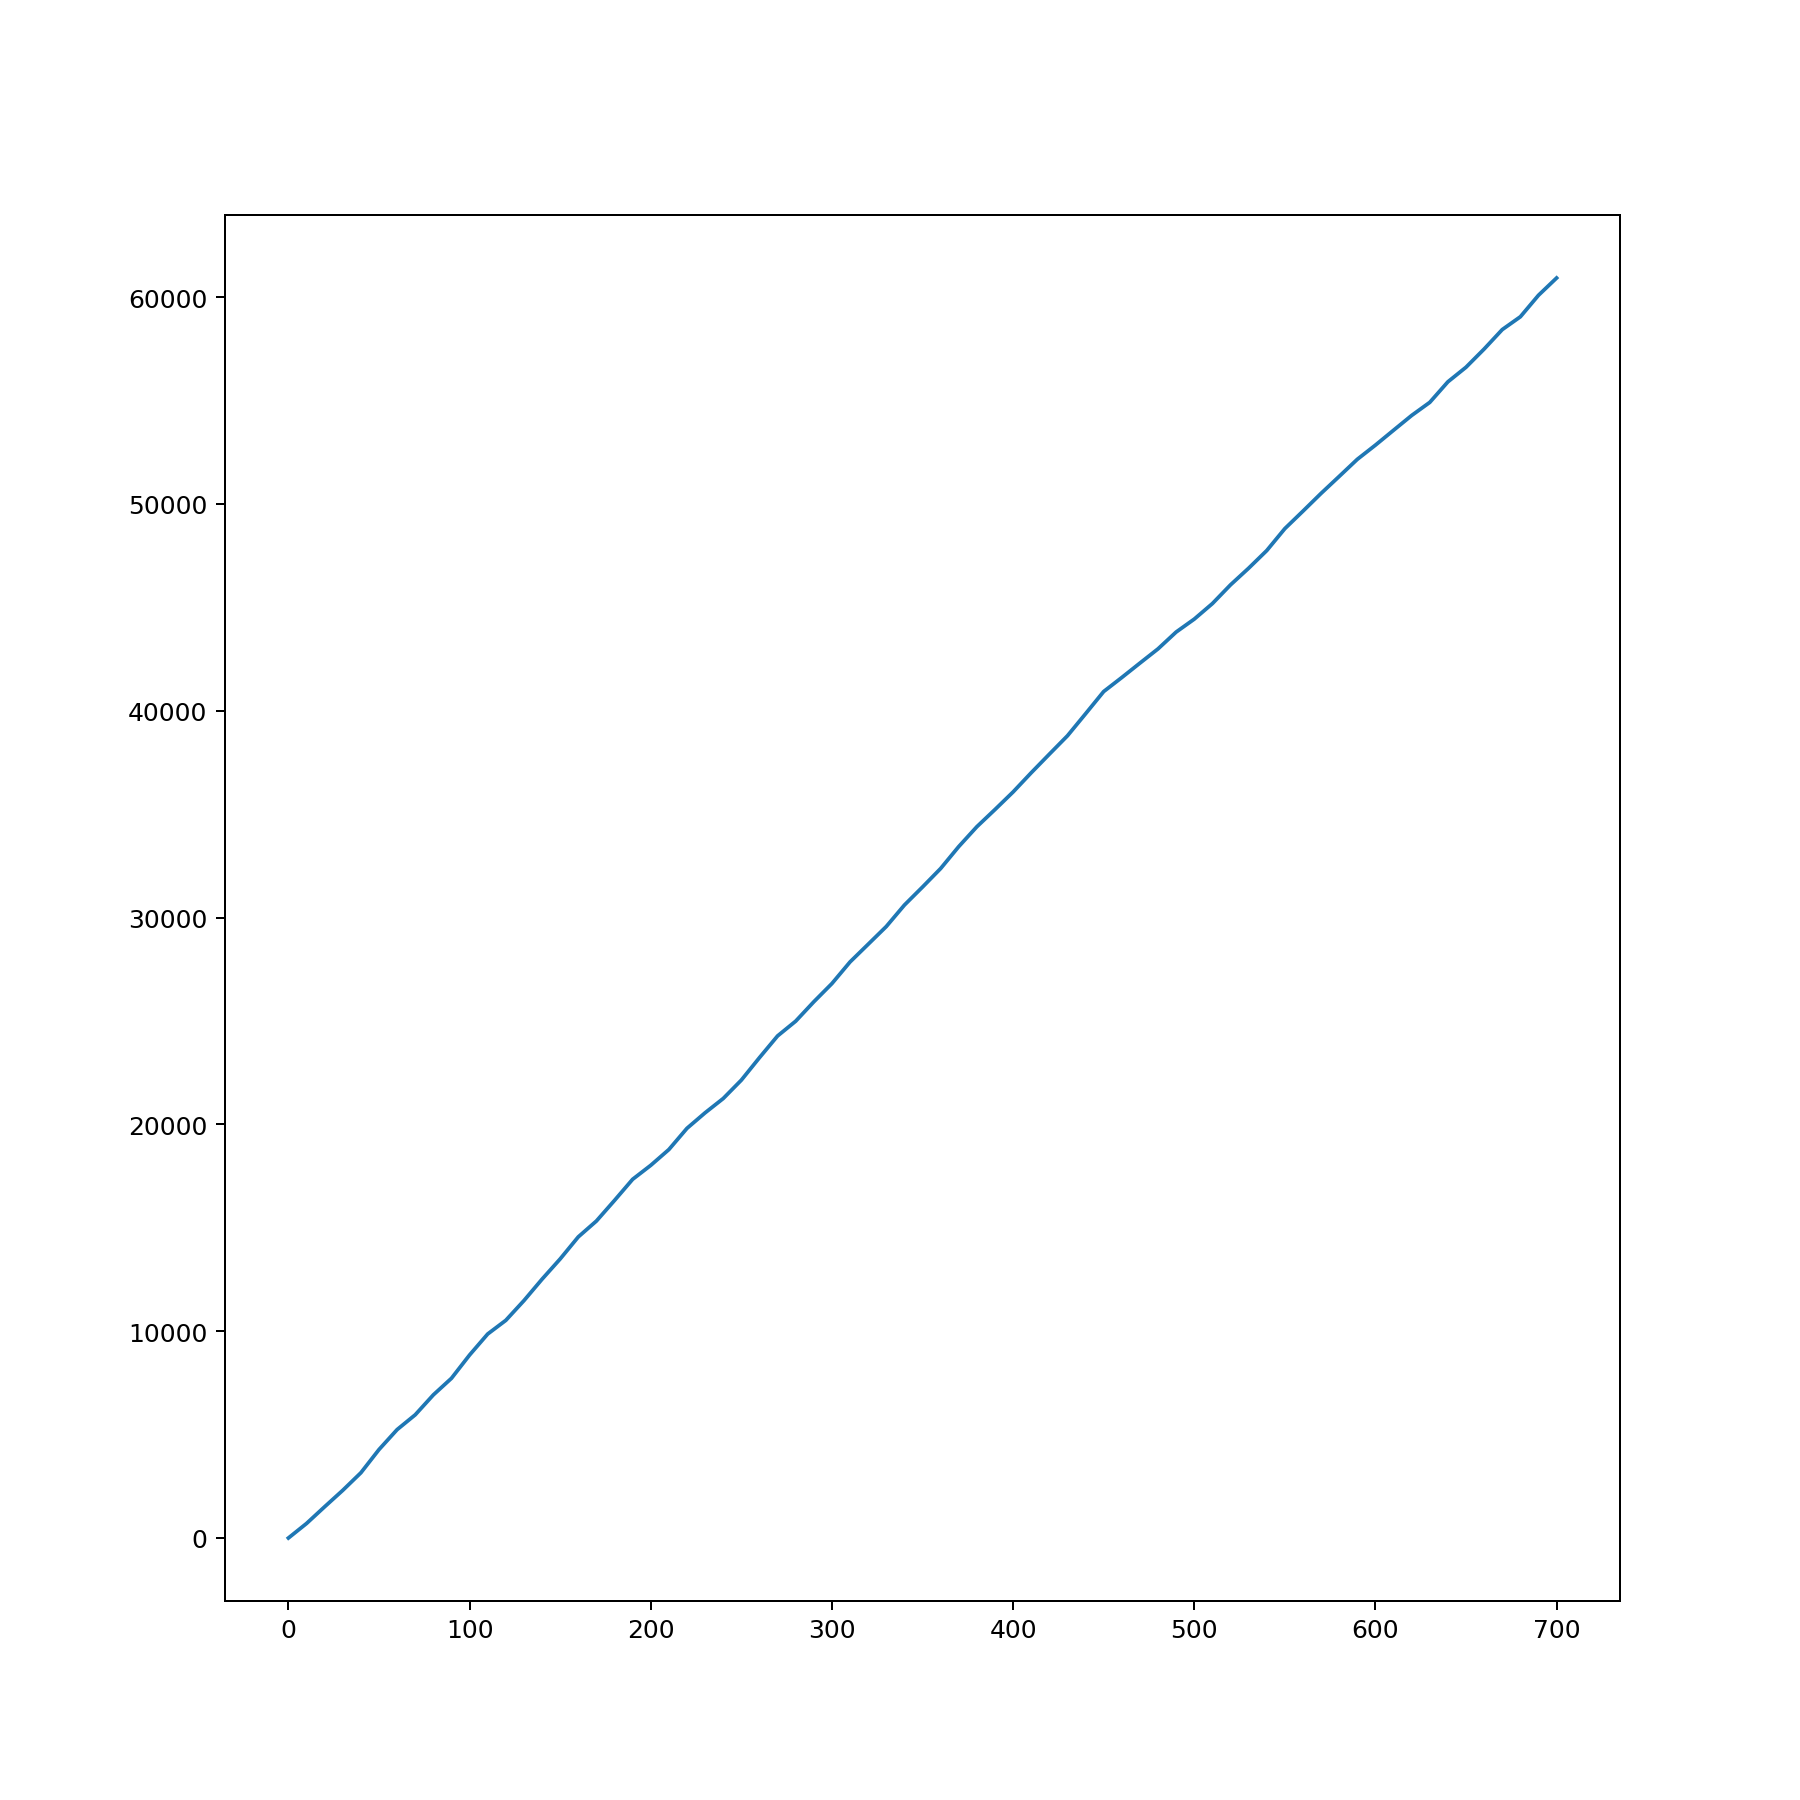

In [74]:
%matplotlib notebook
plt.figure(figsize = (10,10))
plt.plot(x, y_2)
# plt.plot(x, y)
plt.show()

<IPython.core.display.Javascript object>


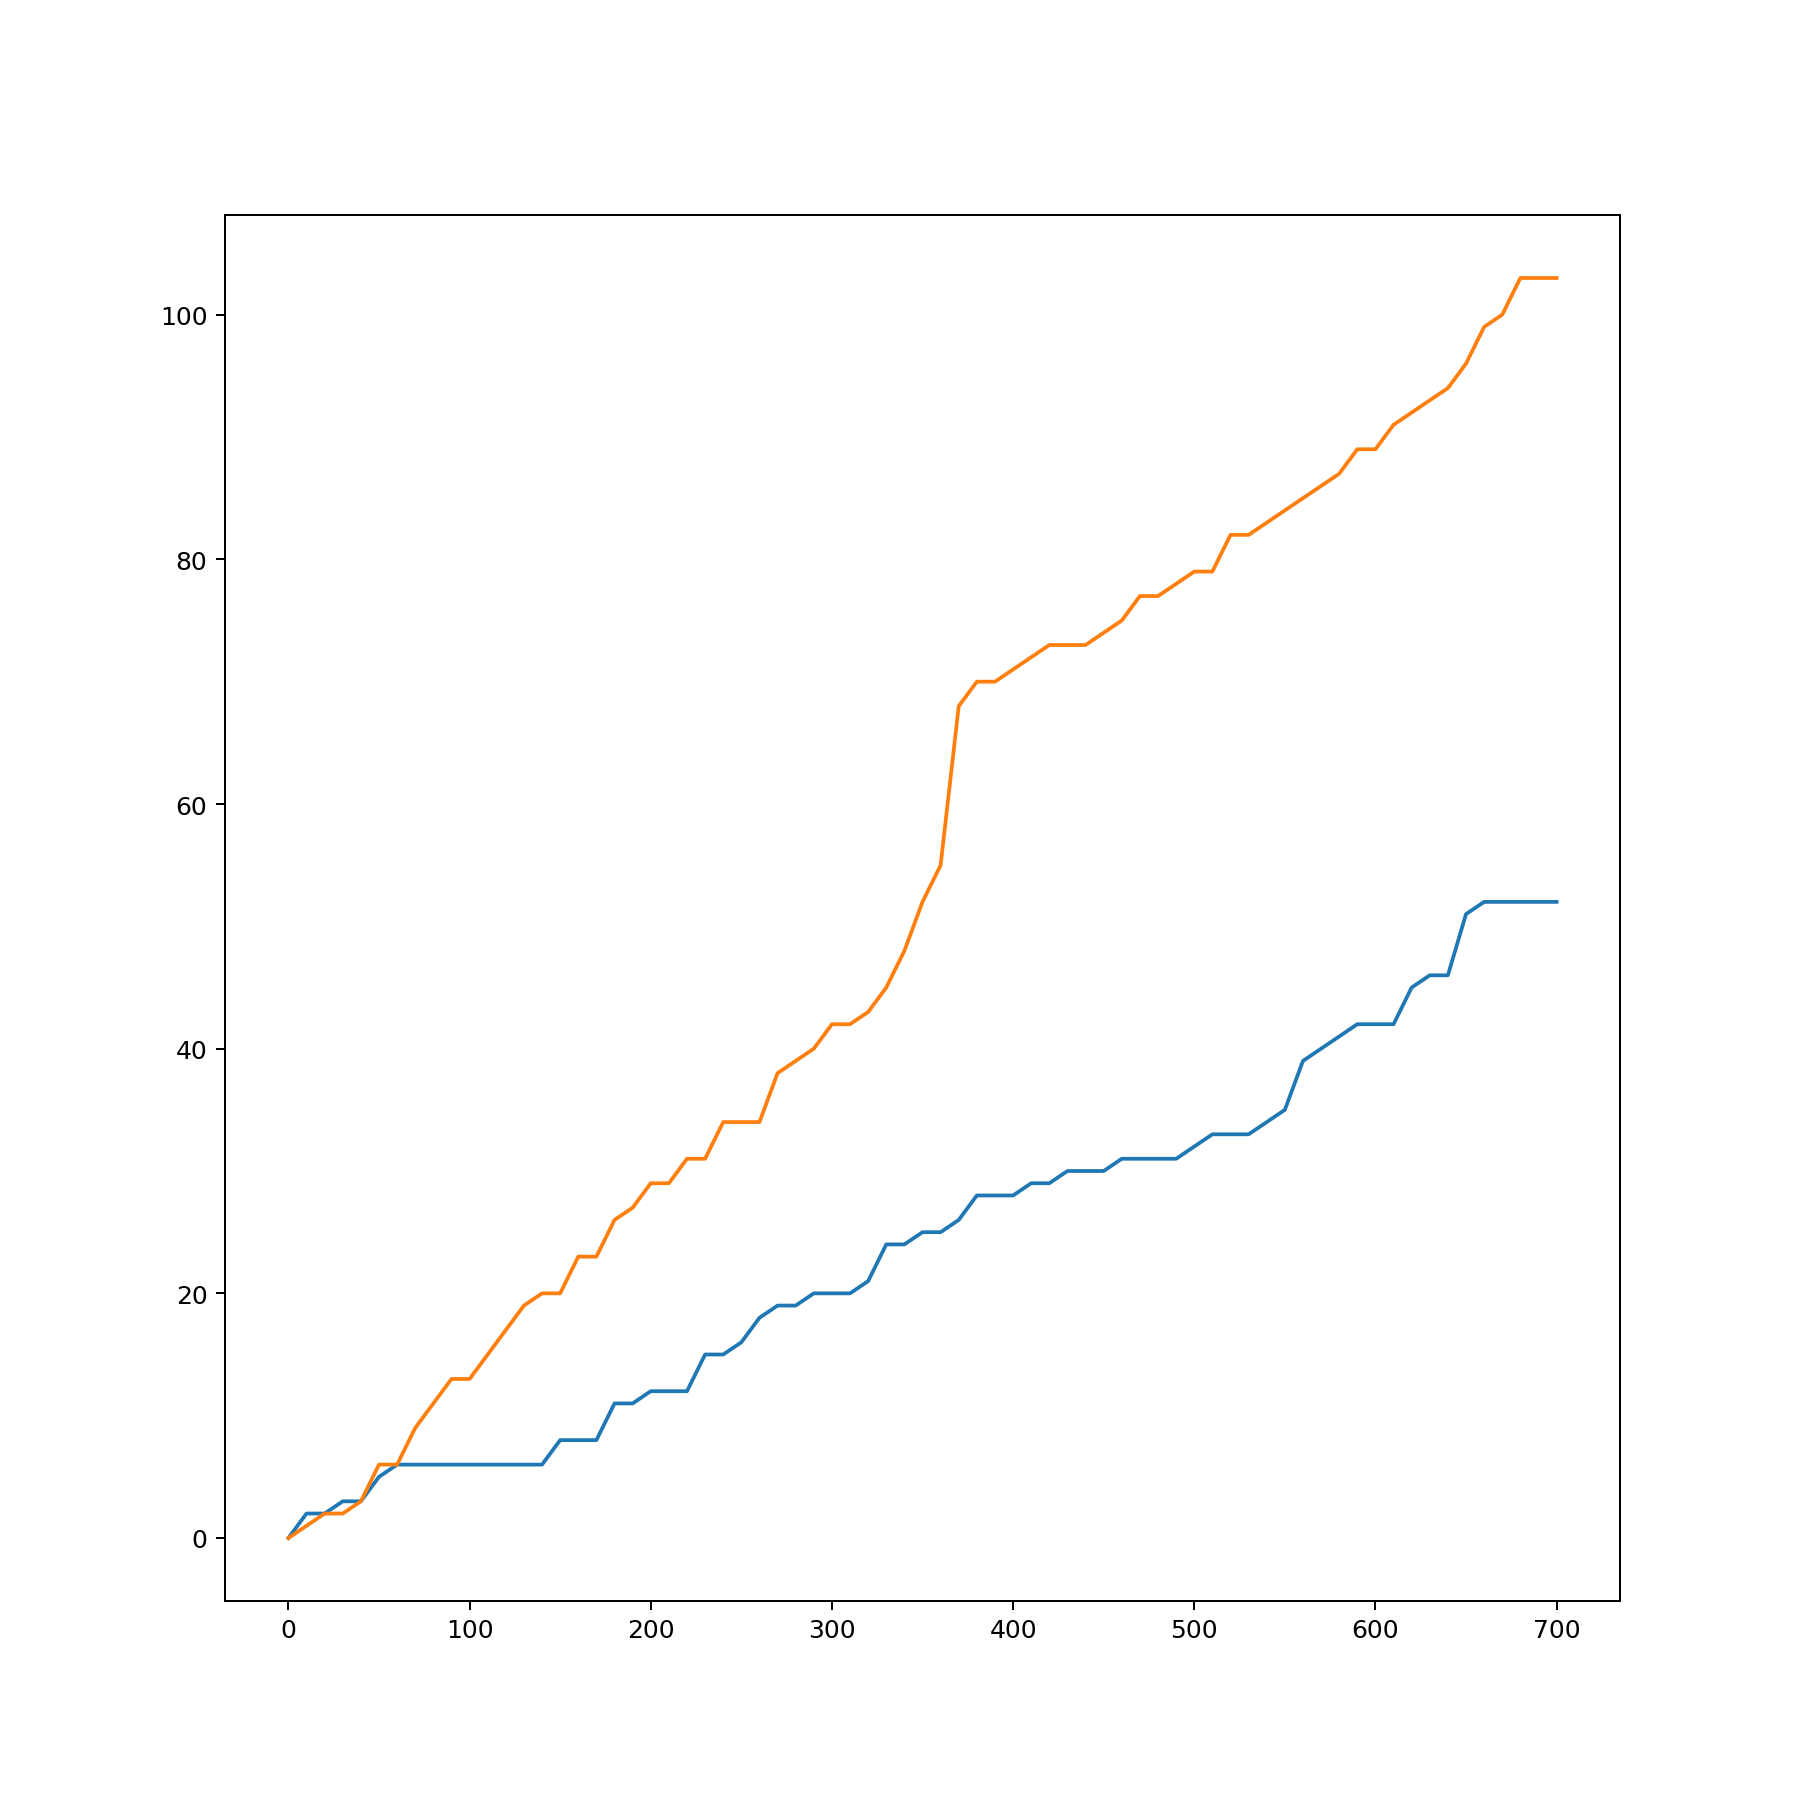

In [34]:
%matplotlib notebook
plt.figure(figsize = (10,10))
plt.plot(x, y2_2)
plt.plot(x, y2)
plt.show()

<IPython.core.display.Javascript object>


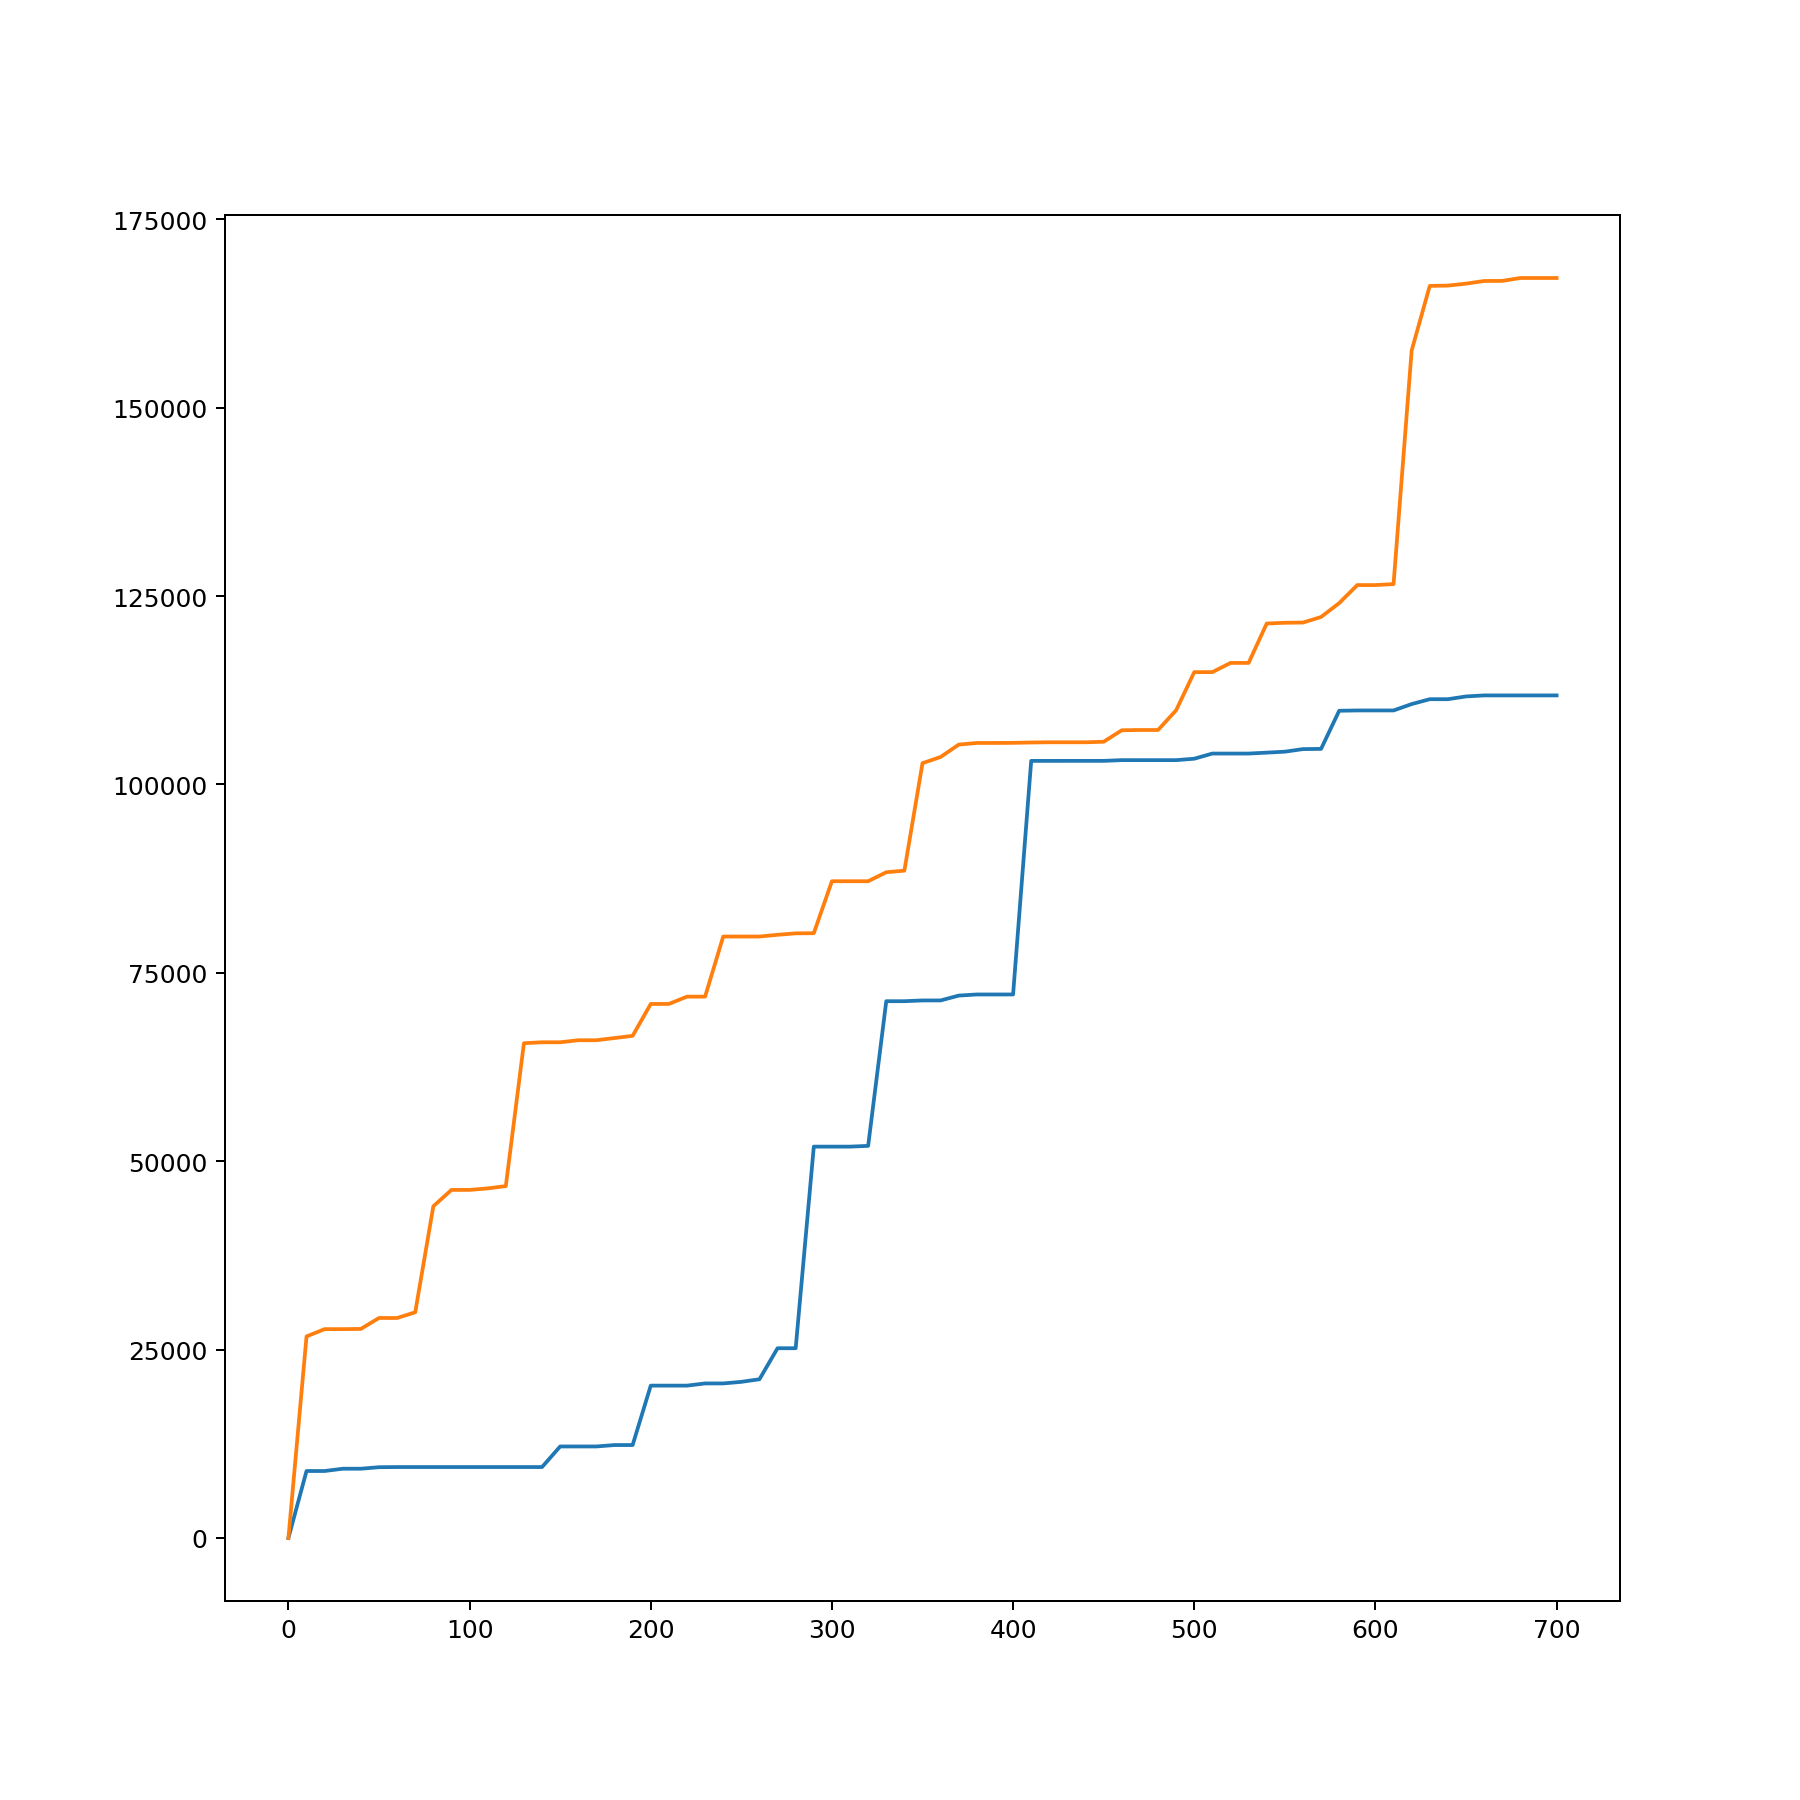

In [35]:
%matplotlib notebook
plt.figure(figsize = (10,10))
plt.plot(x, y3_2)
plt.plot(x, y3)
plt.show()

<IPython.core.display.Javascript object>


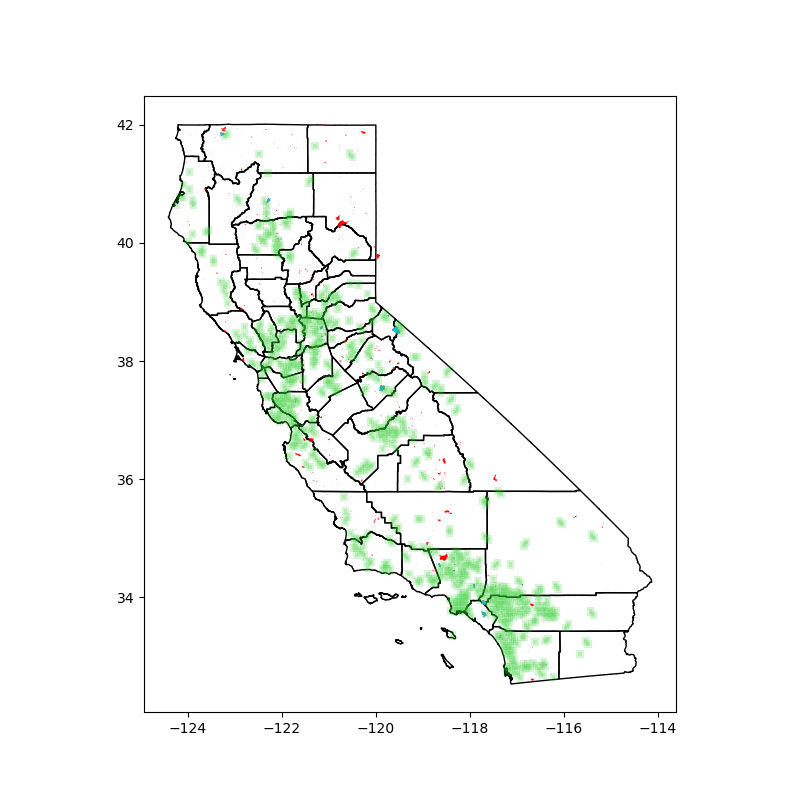

In [19]:
###### Plotting Coverages
%matplotlib notebook
plot_coverages = go_enh_results[-1][1]



ax = world.to_crs(cell.crs).plot(color = "none", edgecolor = 'black', figsize = (8,8))
fires.plot(ax = ax, color = "red")
fires[countcoveredchoose(plot_coverages)].plot(ax= ax, color = "deepskyblue")
for x in plot_coverages:
    indx = x[1]
    minx, miny, maxx, maxy = cell["geometry"][indx].bounds
    if (x[2] == 1):
        pos = (minx, miny)
    if (x[2] == 2):
        pos = (minx, maxy-5*12/n_cells)
    if (x[2] == 3):
        pos = (maxx-5*12/n_cells, maxy-5*12/n_cells)
    if (x[2] == 4):
        pos = (maxx-5*12/n_cells, miny)
    if (x[2] == 5):
        pos = (minx-2*12/n_cells, miny)
    if (x[2] == 6):
        pos = (minx-2*12/n_cells, maxy-5*12/n_cells)
    if (x[2] == 7):
        pos = (maxx-5*12/n_cells, miny-2*12/n_cells)
    if (x[2] == 8):
        pos = (minx, miny-2*12/n_cells)
    if (x[2] == 9):
        pos = (minx-2*12/n_cells, miny-2*12/n_cells)
    rect = plt.Rectangle(pos, 5*12/n_cells, 5*12/n_cells, color="limegreen", linewidth=3, alpha = 0.2)
    ax = ax or plt.gca()
    ax.add_patch(rect)


In [46]:
len(fires)

1451

In [36]:


totalcovered = 0
ansar = np.array([False for i in range(len(fires.clip((-118.5, 34.4, -118.4, 34.6))["geometry"]))])
for x in go_enh_results[-1][1]:
    indx = x[1]
    minx, miny, maxx, maxy = cell["geometry"][indx].bounds
    if (x[2] == 1):
        pos = (minx, miny)
    if (x[2] == 2):
        pos = (minx, maxy-5*12/n_cells)
    if (x[2] == 3):
        pos = (maxx-5*12/n_cells, maxy-5*12/n_cells)
    if (x[2] == 4):
        pos = (maxx-5*12/n_cells, miny)
    if (x[2] == 5):
        pos = (minx-2*12/n_cells, miny)
    if (x[2] == 6):
        pos = (minx-2*12/n_cells, maxy-5*12/n_cells)
    if (x[2] == 7):
        pos = (maxx-5*12/n_cells, miny-2*12/n_cells)
    if (x[2] == 8):
        pos = (minx, miny-2*12/n_cells)
    if (x[2] == 9):
        pos = (minx-2*12/n_cells, miny-2*12/n_cells)
    polygon = Polygon([(pos[0], pos[1]), (pos[0] + 5*12/n_cells, pos[1]), (pos[0] + 5*12/n_cells, pos[1] + 5*12/n_cells), (pos[0], pos[1] + 5*12/n_cells)])
#         coverage_bounds = (pos[0], pos[1], , pos[1] + 5*12/n_cells)
#         print(polygon)
    ansar = np.logical_or(ansar, fires.clip((-118.5, 34.4, -118.4, 34.6))["geometry"].overlaps(polygon))
print (ansar)


51110    False
21147    False
30242    False
280      False
dtype: bool


321

In [65]:
fires.loc[51110].equals(fires.loc[21147])

False

In [64]:
fires.loc[51110]

YEAR_                                                          2021
STATE                                                            CA
AGENCY                                                          CCO
UNIT_ID                                                         LAC
FIRE_NAME                                                   VASQUEZ
INC_NUM                                                    00244896
ALARM_DATE                                      2021-08-06T00:00:00
CONT_DATE                                       2021-08-06T00:00:00
CAUSE                                                          14.0
COMMENTS                                                           
REPORT_AC                                                       NaN
GIS_ACRES                                                  1.501651
C_METHOD                                                        1.0
OBJECTIVE                                                       1.0
FIRE_NUM                                        

In [60]:
fires.loc[30242]

YEAR_                                                          2020
STATE                                                            CA
AGENCY                                                          USF
UNIT_ID                                                         ANF
FIRE_NAME                                                     TEXAS
INC_NUM                                                    00003165
ALARM_DATE                                      2020-08-06T00:00:00
CONT_DATE                                       2020-08-11T00:00:00
CAUSE                                                           2.0
COMMENTS             IRWIN ID 0A96B82F-798A-4368-B6BC-3296B209D7B1 
REPORT_AC                                                       NaN
GIS_ACRES                                                209.950653
C_METHOD                                                        3.0
OBJECTIVE                                                       1.0
FIRE_NUM                                        

In [61]:
fires.loc[280]

YEAR_                                                          2020
STATE                                                            CA
AGENCY                                                          USF
UNIT_ID                                                         ANF
FIRE_NAME                                                     TEXAS
INC_NUM                                                    00003165
ALARM_DATE                                      2020-08-06T00:00:00
CONT_DATE                                       2020-08-11T00:00:00
CAUSE                                                           2.0
COMMENTS             IRWIN ID 0A96B82F-798A-4368-B6BC-3296B209D7B1 
REPORT_AC                                                     210.0
GIS_ACRES                                                209.950653
C_METHOD                                                        3.0
OBJECTIVE                                                       1.0
FIRE_NUM                                        

In [58]:
fires["geometry"].duplicated().sum()

321

In [59]:
len(fires["geometry"])

797

In [45]:
fires.duplicated().sum()

0

<IPython.core.display.Javascript object>


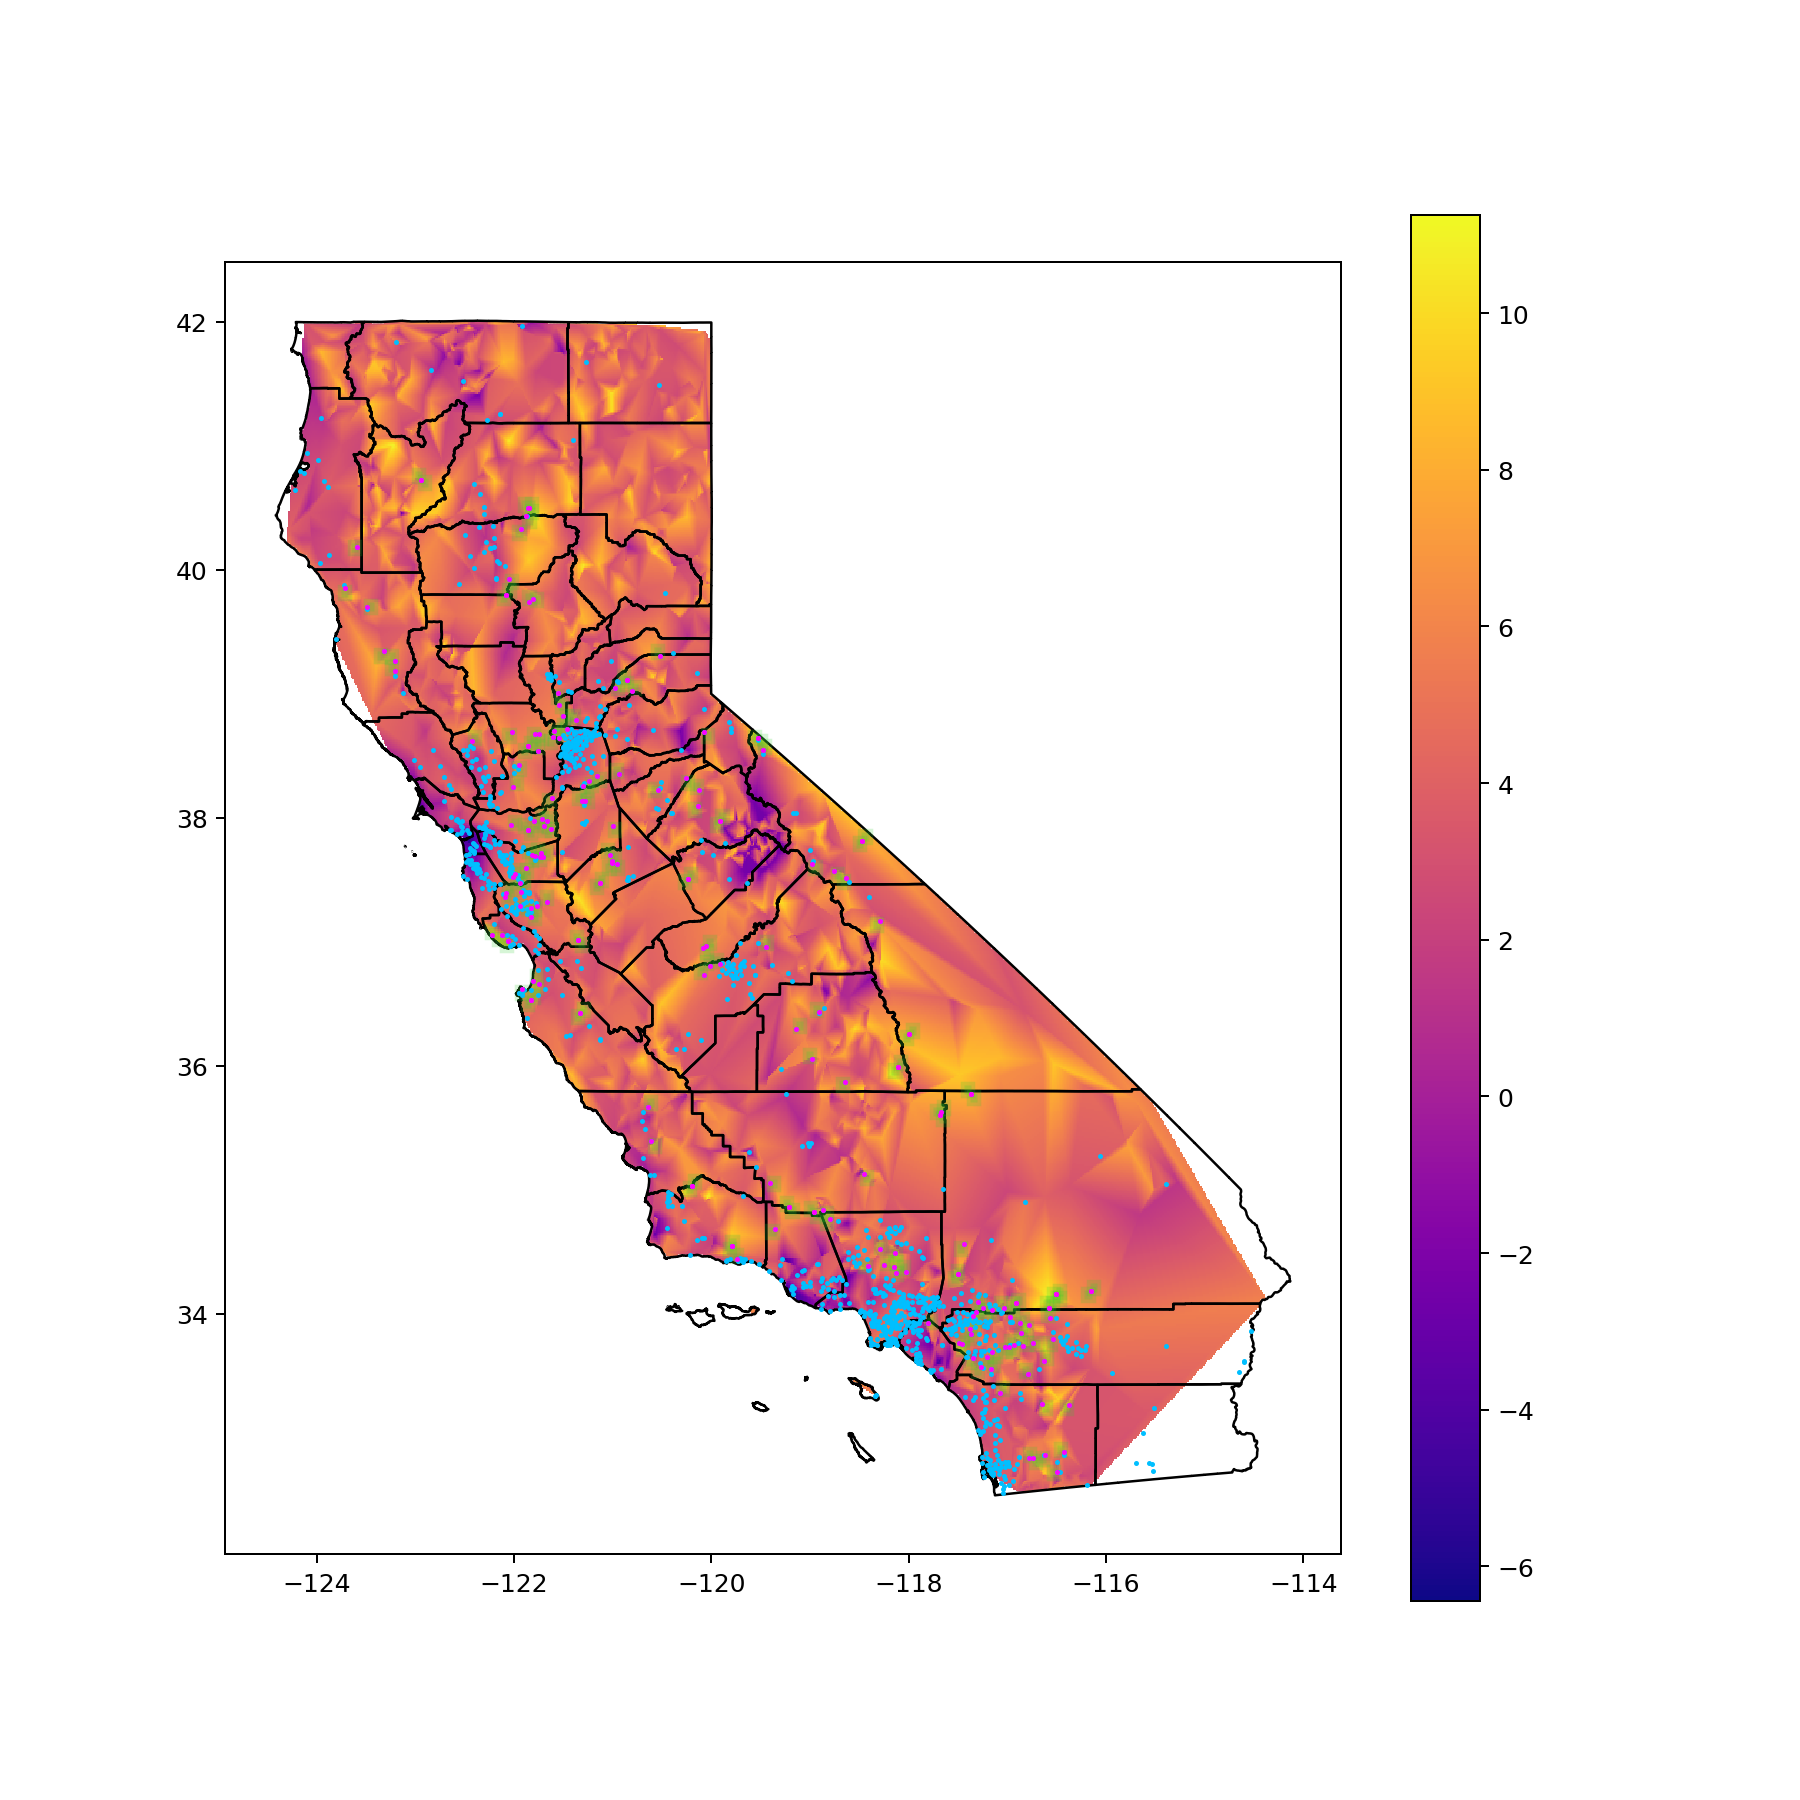

In [14]:
###### Plotting Coverages
%matplotlib notebook
plot_coverages = go_enh_results[20][1]


choose = [x[3] for x in plot_coverages]
ax = plotter(dataframe)
for x in plot_coverages:
    indx = x[1]
    minx, miny, maxx, maxy = cell["geometry"][indx].bounds
    if (x[2] == 1):
        pos = (minx, miny)
    if (x[2] == 2):
        pos = (minx, maxy-5*12/n_cells)
    if (x[2] == 3):
        pos = (maxx-5*12/n_cells, maxy-5*12/n_cells)
    if (x[2] == 4):
        pos = (maxx-5*12/n_cells, miny)
    if (x[2] == 5):
        pos = (minx-2*12/n_cells, miny)
    if (x[2] == 6):
        pos = (minx-2*12/n_cells, maxy-5*12/n_cells)
    if (x[2] == 7):
        pos = (maxx-5*12/n_cells, miny-2*12/n_cells)
    if (x[2] == 8):
        pos = (minx, miny-2*12/n_cells)
    if (x[2] == 9):
        pos = (minx-2*12/n_cells, miny-2*12/n_cells)
    rect = plt.Rectangle(pos, 5*12/n_cells, 5*12/n_cells, color="limegreen", linewidth=3, alpha = 0.2)
    ax = ax or plt.gca()
    ax.add_patch(rect)
# plt.scatter(fire_station_points["geometry"].x, fire_station_points["geometry"].y, s = 1, color="deepskyblue")
plt.scatter(fire_station_points["geometry"][choose].x, fire_station_points["geometry"][choose].y, s = 1, color="magenta")

In [15]:
len(go_enh_results)

71

In [52]:
print(countcovered(coverages))

/Users/christopher/anaconda3/lib/python3.10/site-packages/shapely/predicates.py:853: RuntimeWarning: invalid value encountered in overlaps
  return lib.overlaps(a, b, **kwargs)


216


<IPython.core.display.Javascript object>


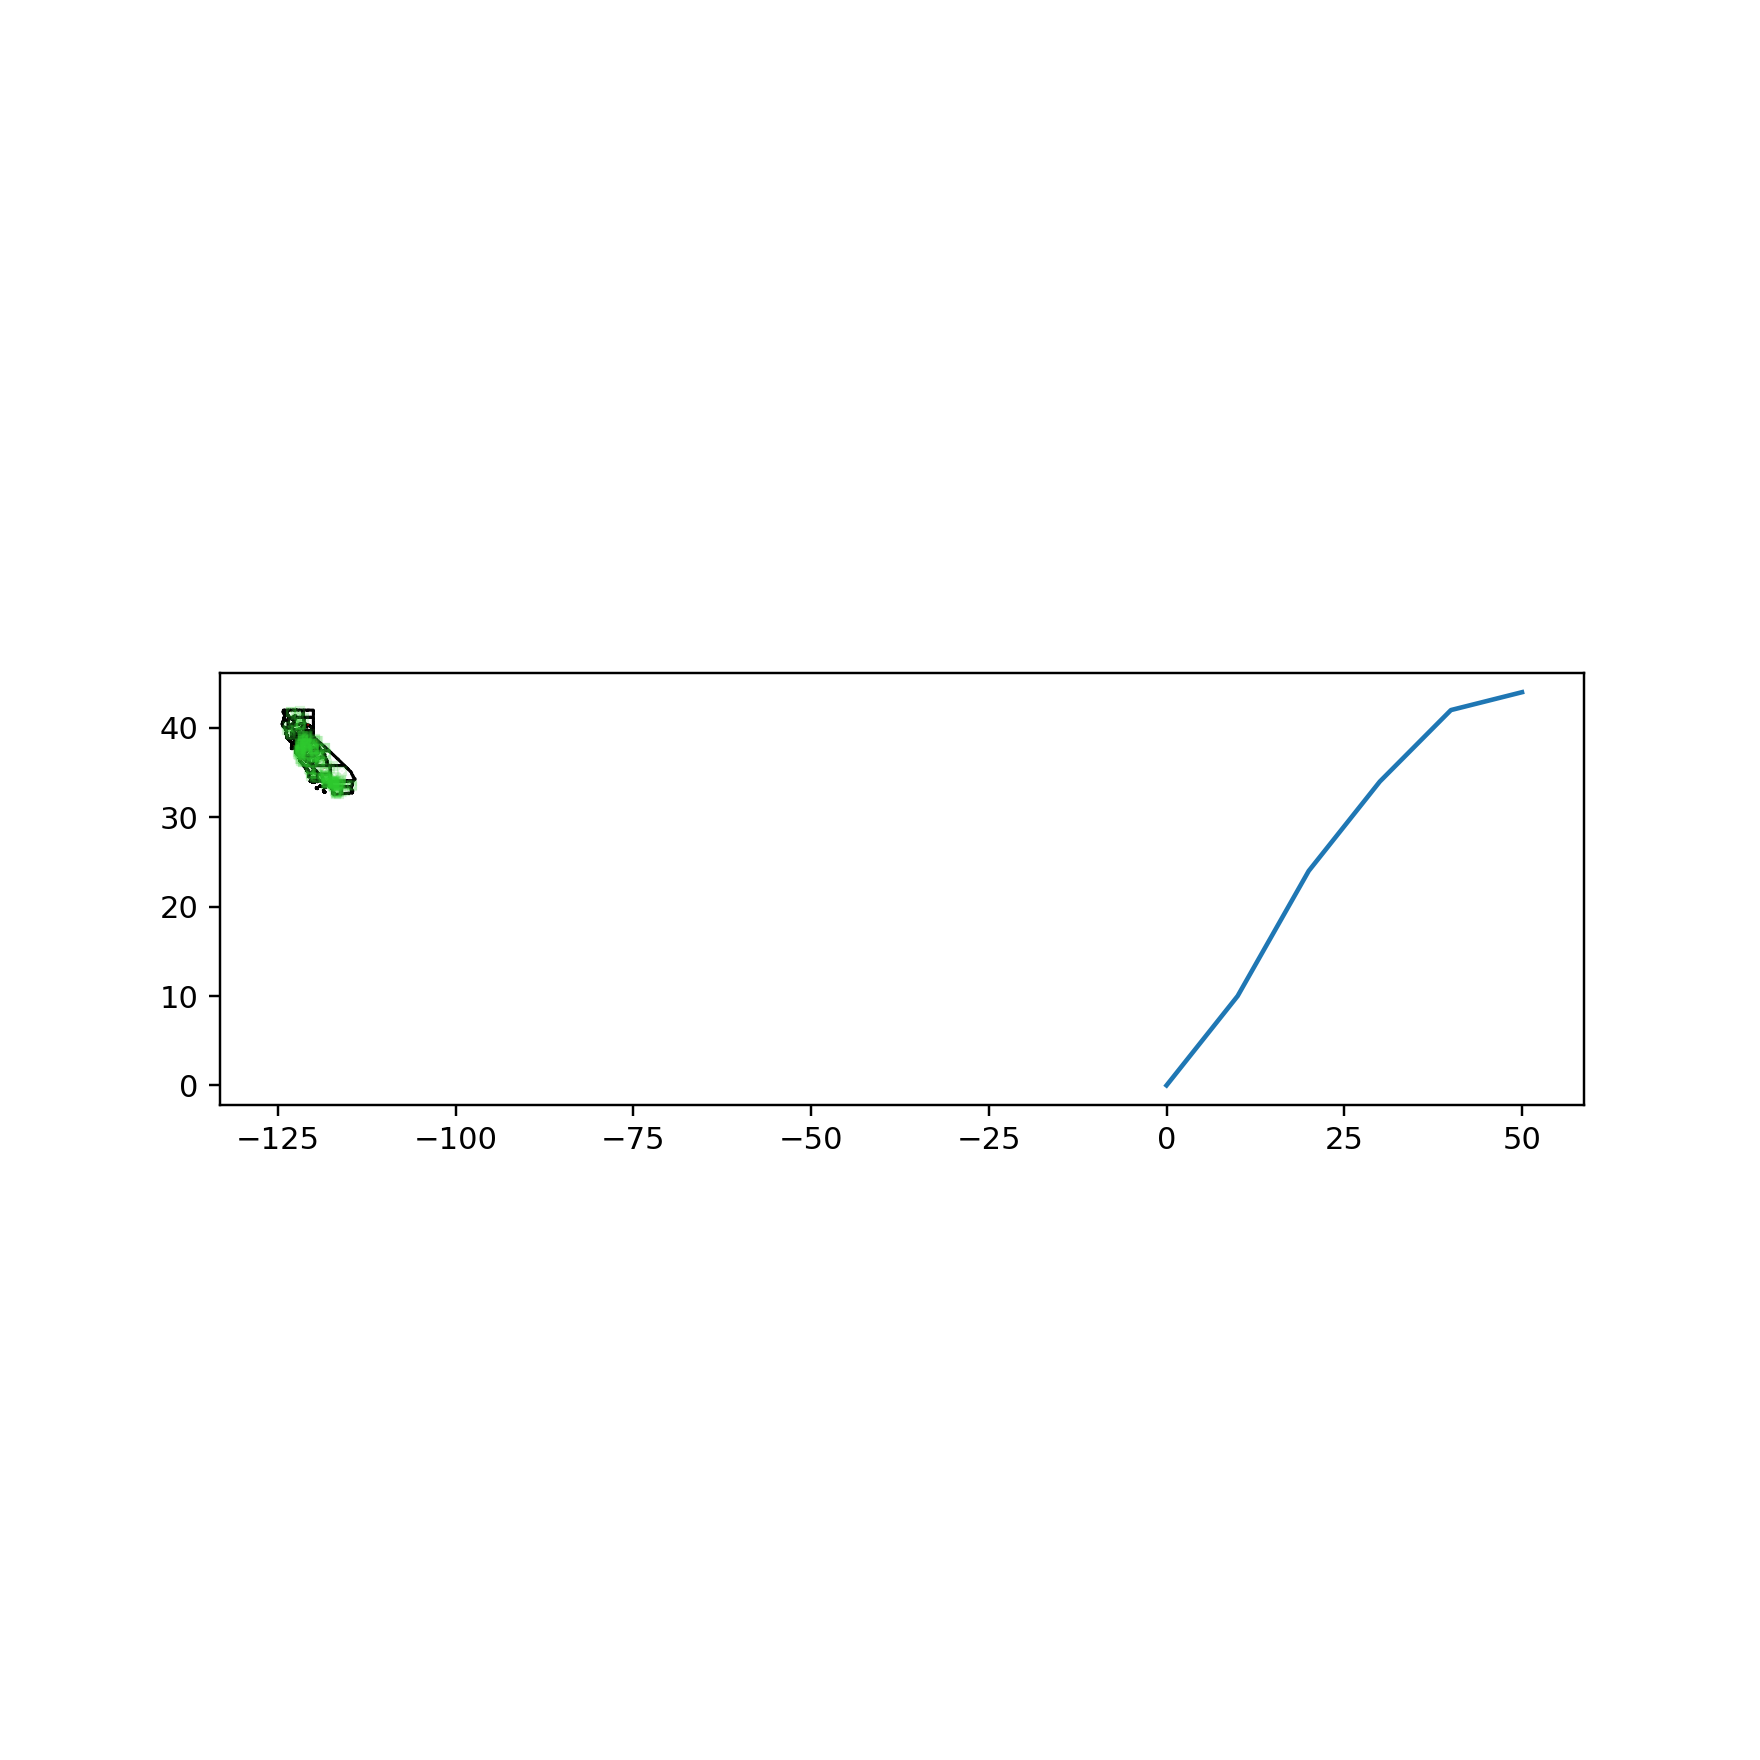